# Results and Discussion: Figures generation

In [1]:
import numpy as np
import numba as nb
from numba import njit, prange
import time

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import importlib

# --- Core code helpers ---
import src.core_helpers
importlib.reload(src.core_helpers)
from src.core_helpers import *

# --- Core Synthetic data ---
import src.core_SynData
importlib.reload(src.core_SynData)
from src.core_SynData import *

# --- Solvers ---
import src.core_Solvers
importlib.reload(src.core_Solvers)
from src.core_Solvers import *

# --- Figures ---
import src.core_Figures
importlib.reload(src.core_Figures)
from src.core_Figures import *

### VKU $P_{max}$ - $\beta$ relationship

In [3]:
VKU_Pmax = 126      # [MW]
VKU_beta_GL = 0.6196
VKU_beta_SL = 0.7157
s_ratio = (1/VKU_beta_SL) / VKU_Pmax
print(f"s_ratio: {s_ratio}")

s_ratio: 0.011089154585032747


### Simulation Parameters 

In [4]:
# --- Simulation Parameters ---
N = 50000000
grid = 1001
r = 0.01*60                 # 1/HR
tau = 0.0 
dt = 1/60                   # 1/HR
beta = 0.6               # min/MW
Pmax = (1/beta)/s_ratio
alpha = r*Pmax           # MW/HR]

a = alpha * dt           # MW
a_tilde = beta * a
print(f"Pmax: {Pmax}")
print(f"alpha value: {alpha} \na value: {a} \na_tilde value: {a_tilde}")

# --- Parameters for infinity limit ---
Pmax_inf = 10000000

# --- Simulation grid for P99 figures ---
r_values = np.linspace(0.1, 3.5, 50) / (beta * Pmax)    # [1/MIN]
alpha_values = r_values*60*Pmax                       # [MW/HR] (ALPHA)
a_values = alpha_values * dt                          # [MW/MIN]
a_tilde_values = beta * a_values
print(f"min(alpha_values): {min(alpha_values)}, max(alpha_values): {max(alpha_values)}")
print(f"min(a_values): {min(a_values)}, max(alpha_values): {max(a_values)}")
print(f"min(a_values): {min(a_tilde_values)}, max(a_values): {max(a_tilde_values)}")

Pmax: 150.297
alpha value: 90.17819999999999 
a value: 1.50297 
a_tilde value: 0.9017819999999999
min(alpha_values): 10.000000000000002, max(alpha_values): 350.00000000000006
min(a_values): 0.16666666666666669, max(alpha_values): 5.833333333333334
min(a_values): 0.1, max(a_values): 3.5000000000000004


### Synthetic data

In [5]:
# --- SIMPLE LAPLACE TIME SERIES ---
rng = np.random.default_rng(7)
seed = rng.random(N)
Y, P = simulate_Y_P_SL(N, Pmax, 55, beta, seed)

# --- Taking P0 -> infinity ---
rng = np.random.default_rng(7)
seed = rng.random(N)
Y_inf, P_inf = simulate_Y_P_SL(N, Pmax_inf, 55, beta, seed)


# --- GENERALIZED LAPLACE TIME SERIES ---
c = 0.25
c2 = 1.0 - c
zeta = 10
beta_gl = beta * np.sqrt(c/(zeta**2) + c2)
b = zeta * beta_gl

rng = np.random.default_rng(7)
bernoulli_exp = rng.random(N)  
seeds = rng.random(N)          
Y_GL, P_GL = simulate_Y_P_GL(N, Pmax_inf, 77, c, c2, b, beta_gl, bernoulli_exp, seeds)

### RQ 1.1: How does the theoretical results predict the empirical pdf/cdf

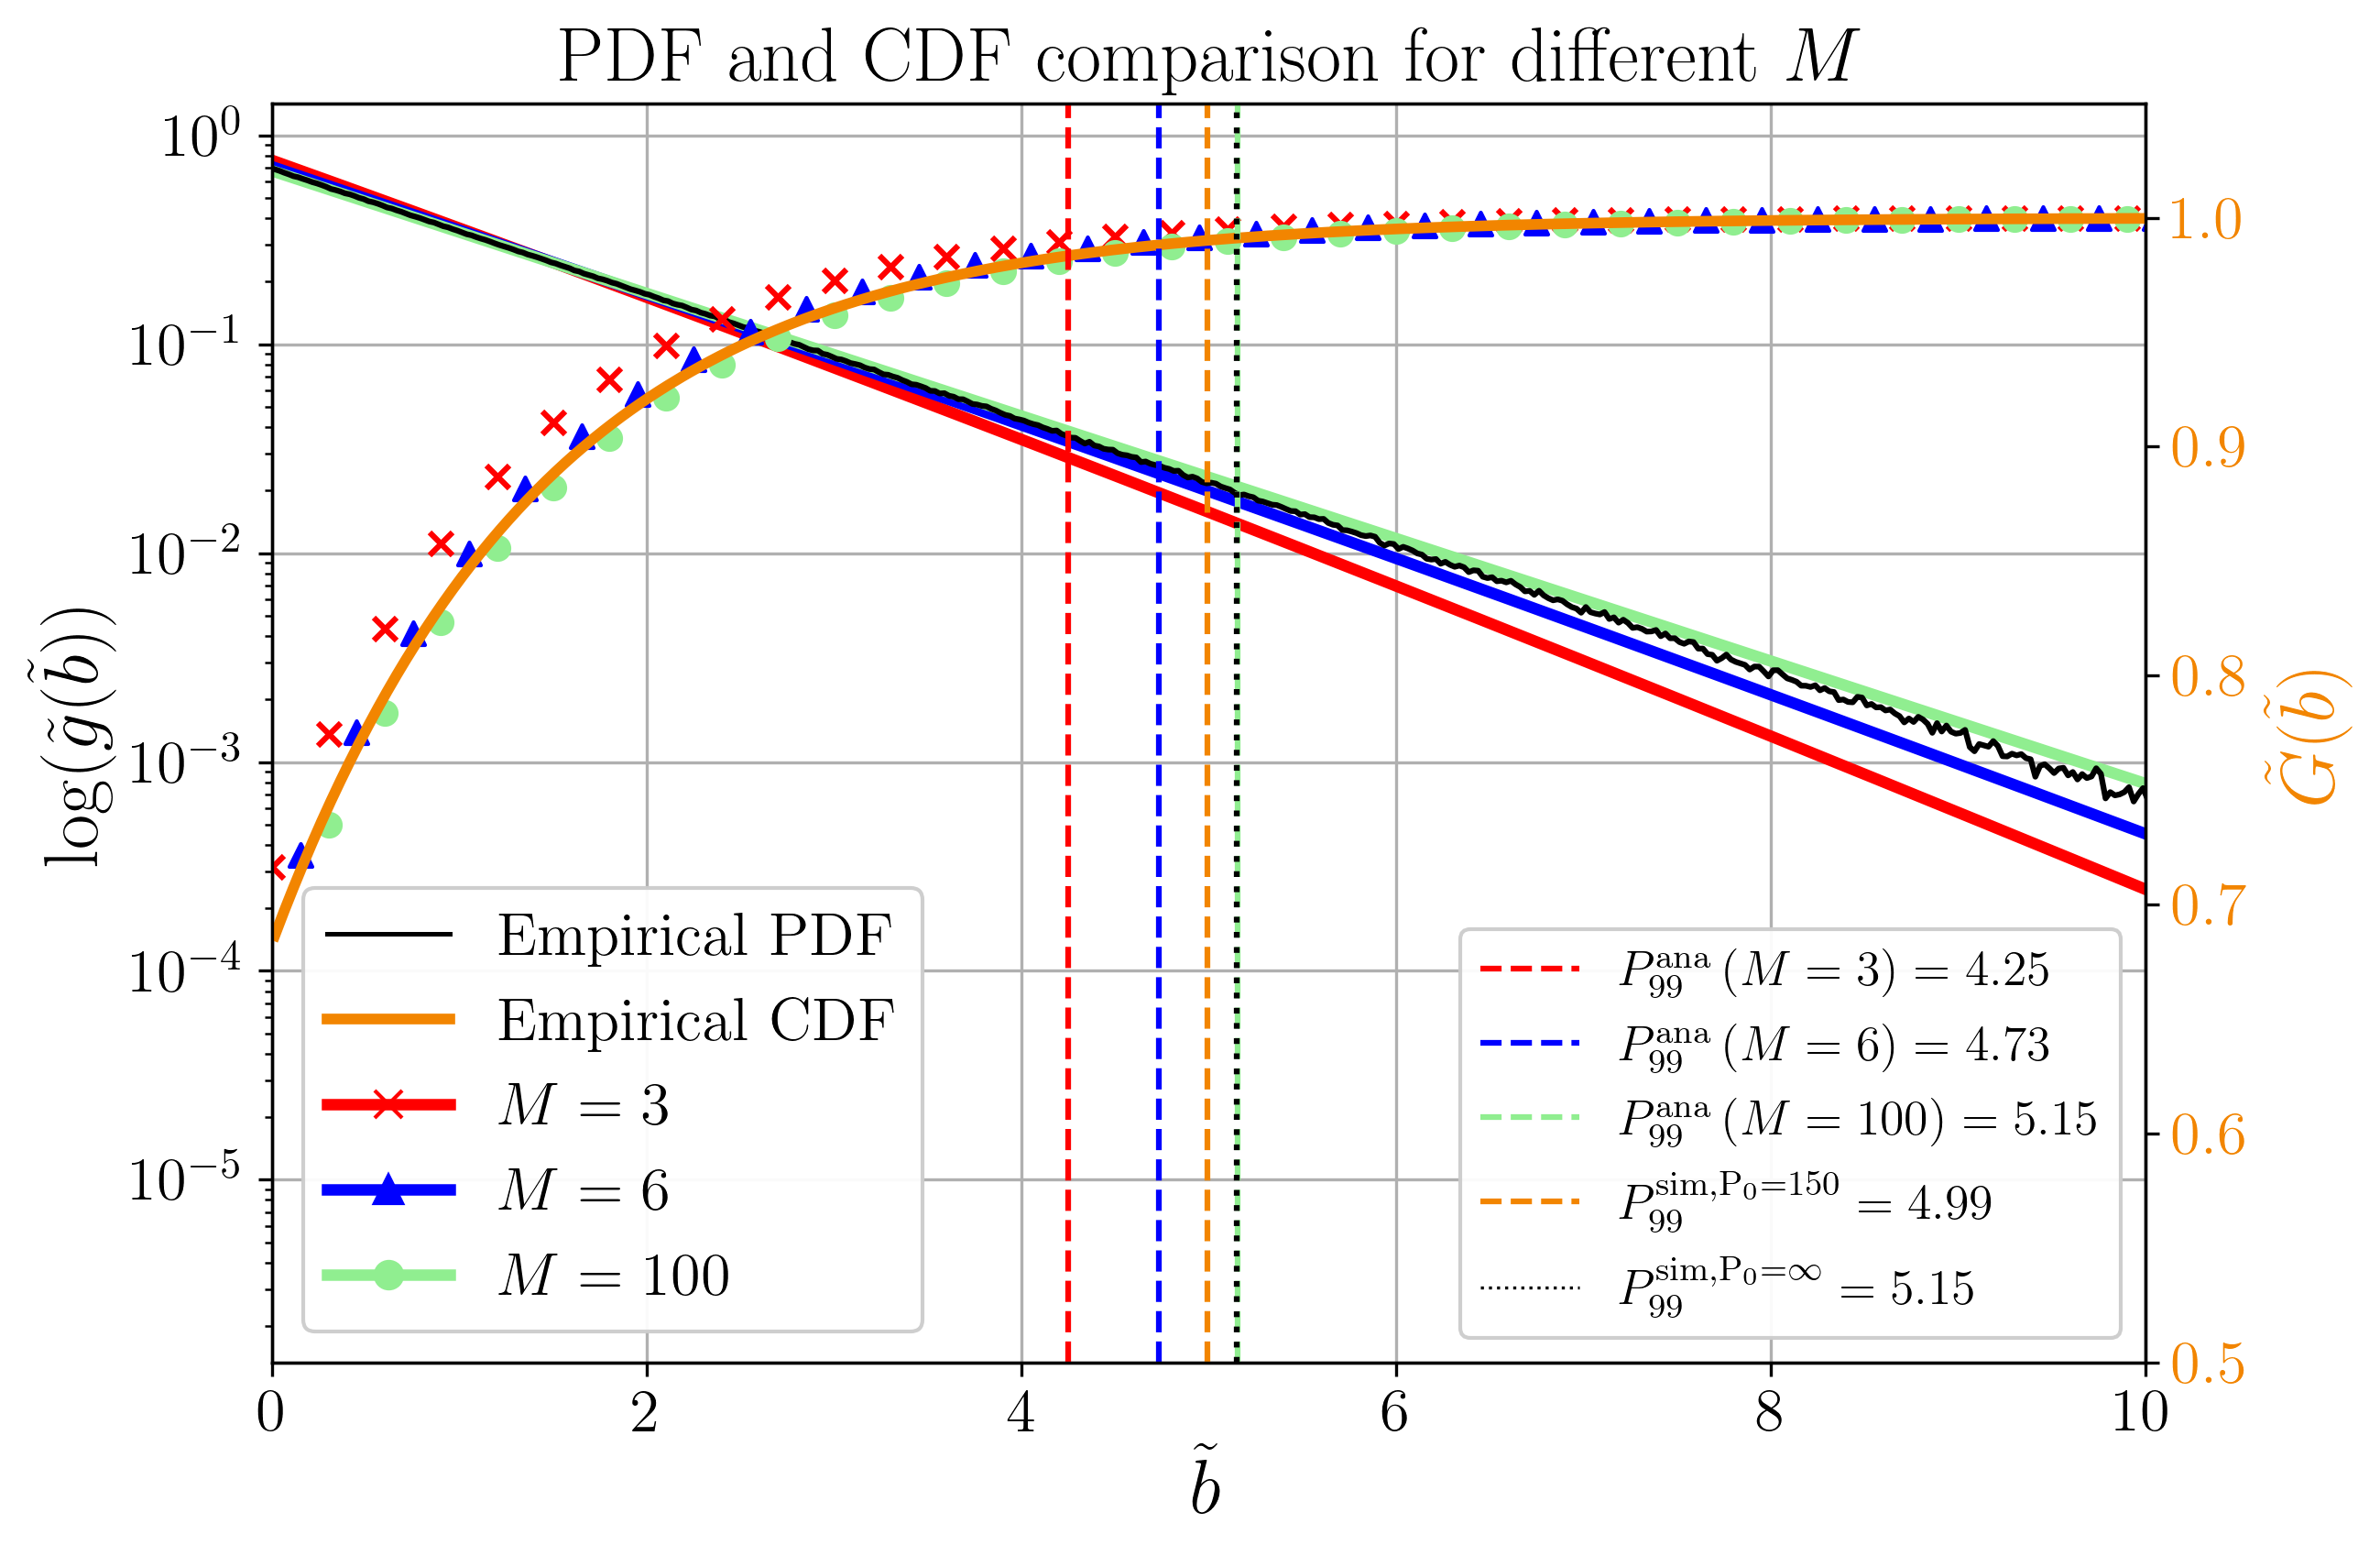

In [5]:
BESS, b_grid, g_sim, p0_sim, p99_sim = algorithmic_solution(a_tilde, beta, P, dt, grid)

# --- Analytical solver ---
M_values = np.array([3, 6, 100])
g_ana_list = []
p99_values = []; p99_values.append(p99_sim)
for M_val in M_values:
    b_ana, g_ana, p0_ana, p99_ana = analytical_solution(
            a, beta, M_val, b_max=15, n_grid=grid
        )
    g_ana_list.append((b_ana, g_ana, p0_ana))
    p99_values.append(p99_ana)
p99_values = np.asarray(p99_values)


# ------ CDF FIGURE COMPARISION FOR DIFFERENT M VALUES ------
b_ana5, g_ana5, p0_ana5 = g_ana_list[0]
G_ana3 = cdf_trapz_calculator(b_ana5, g_ana5, p0_ana5)

b_ana10, g_ana10, p0_ana10 = g_ana_list[1]
G_ana6 = cdf_trapz_calculator(b_ana10, g_ana10, p0_ana10)

b_ana100, g_ana100, p0_ana100 = g_ana_list[2]
G_ana100 = cdf_trapz_calculator(b_ana100, g_ana100, p0_ana100)

Counts, Bins = np.histogram(BESS, bins=grid, density=True)
B_sim = 0.5 * (Bins[:-1] + Bins[1:])
G_sim = np.cumsum(Counts) * (Bins[1] - Bins[0])


# --- P99 value for P0 -> infinity ---
_, _, _, _, p99_inf = algorithmic_solution(a_tilde, beta, P_inf, dt, grid)

# --- FIGURE ---
simulation = b_grid, g_sim, G_sim 
analytical = b_ana, g_ana_list, G_ana3, G_ana6, G_ana100

RQ_11_FIGURE(simulation, analytical, p99_values, p99_inf, M_values)

### RQ 1.2: How does results translate into calculations for P99

c:\Users\Diego\Documents\UNI\6 SEM\BESS Sizing\BESS_Sizing_Simulator\src\core_Figures.py:251: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


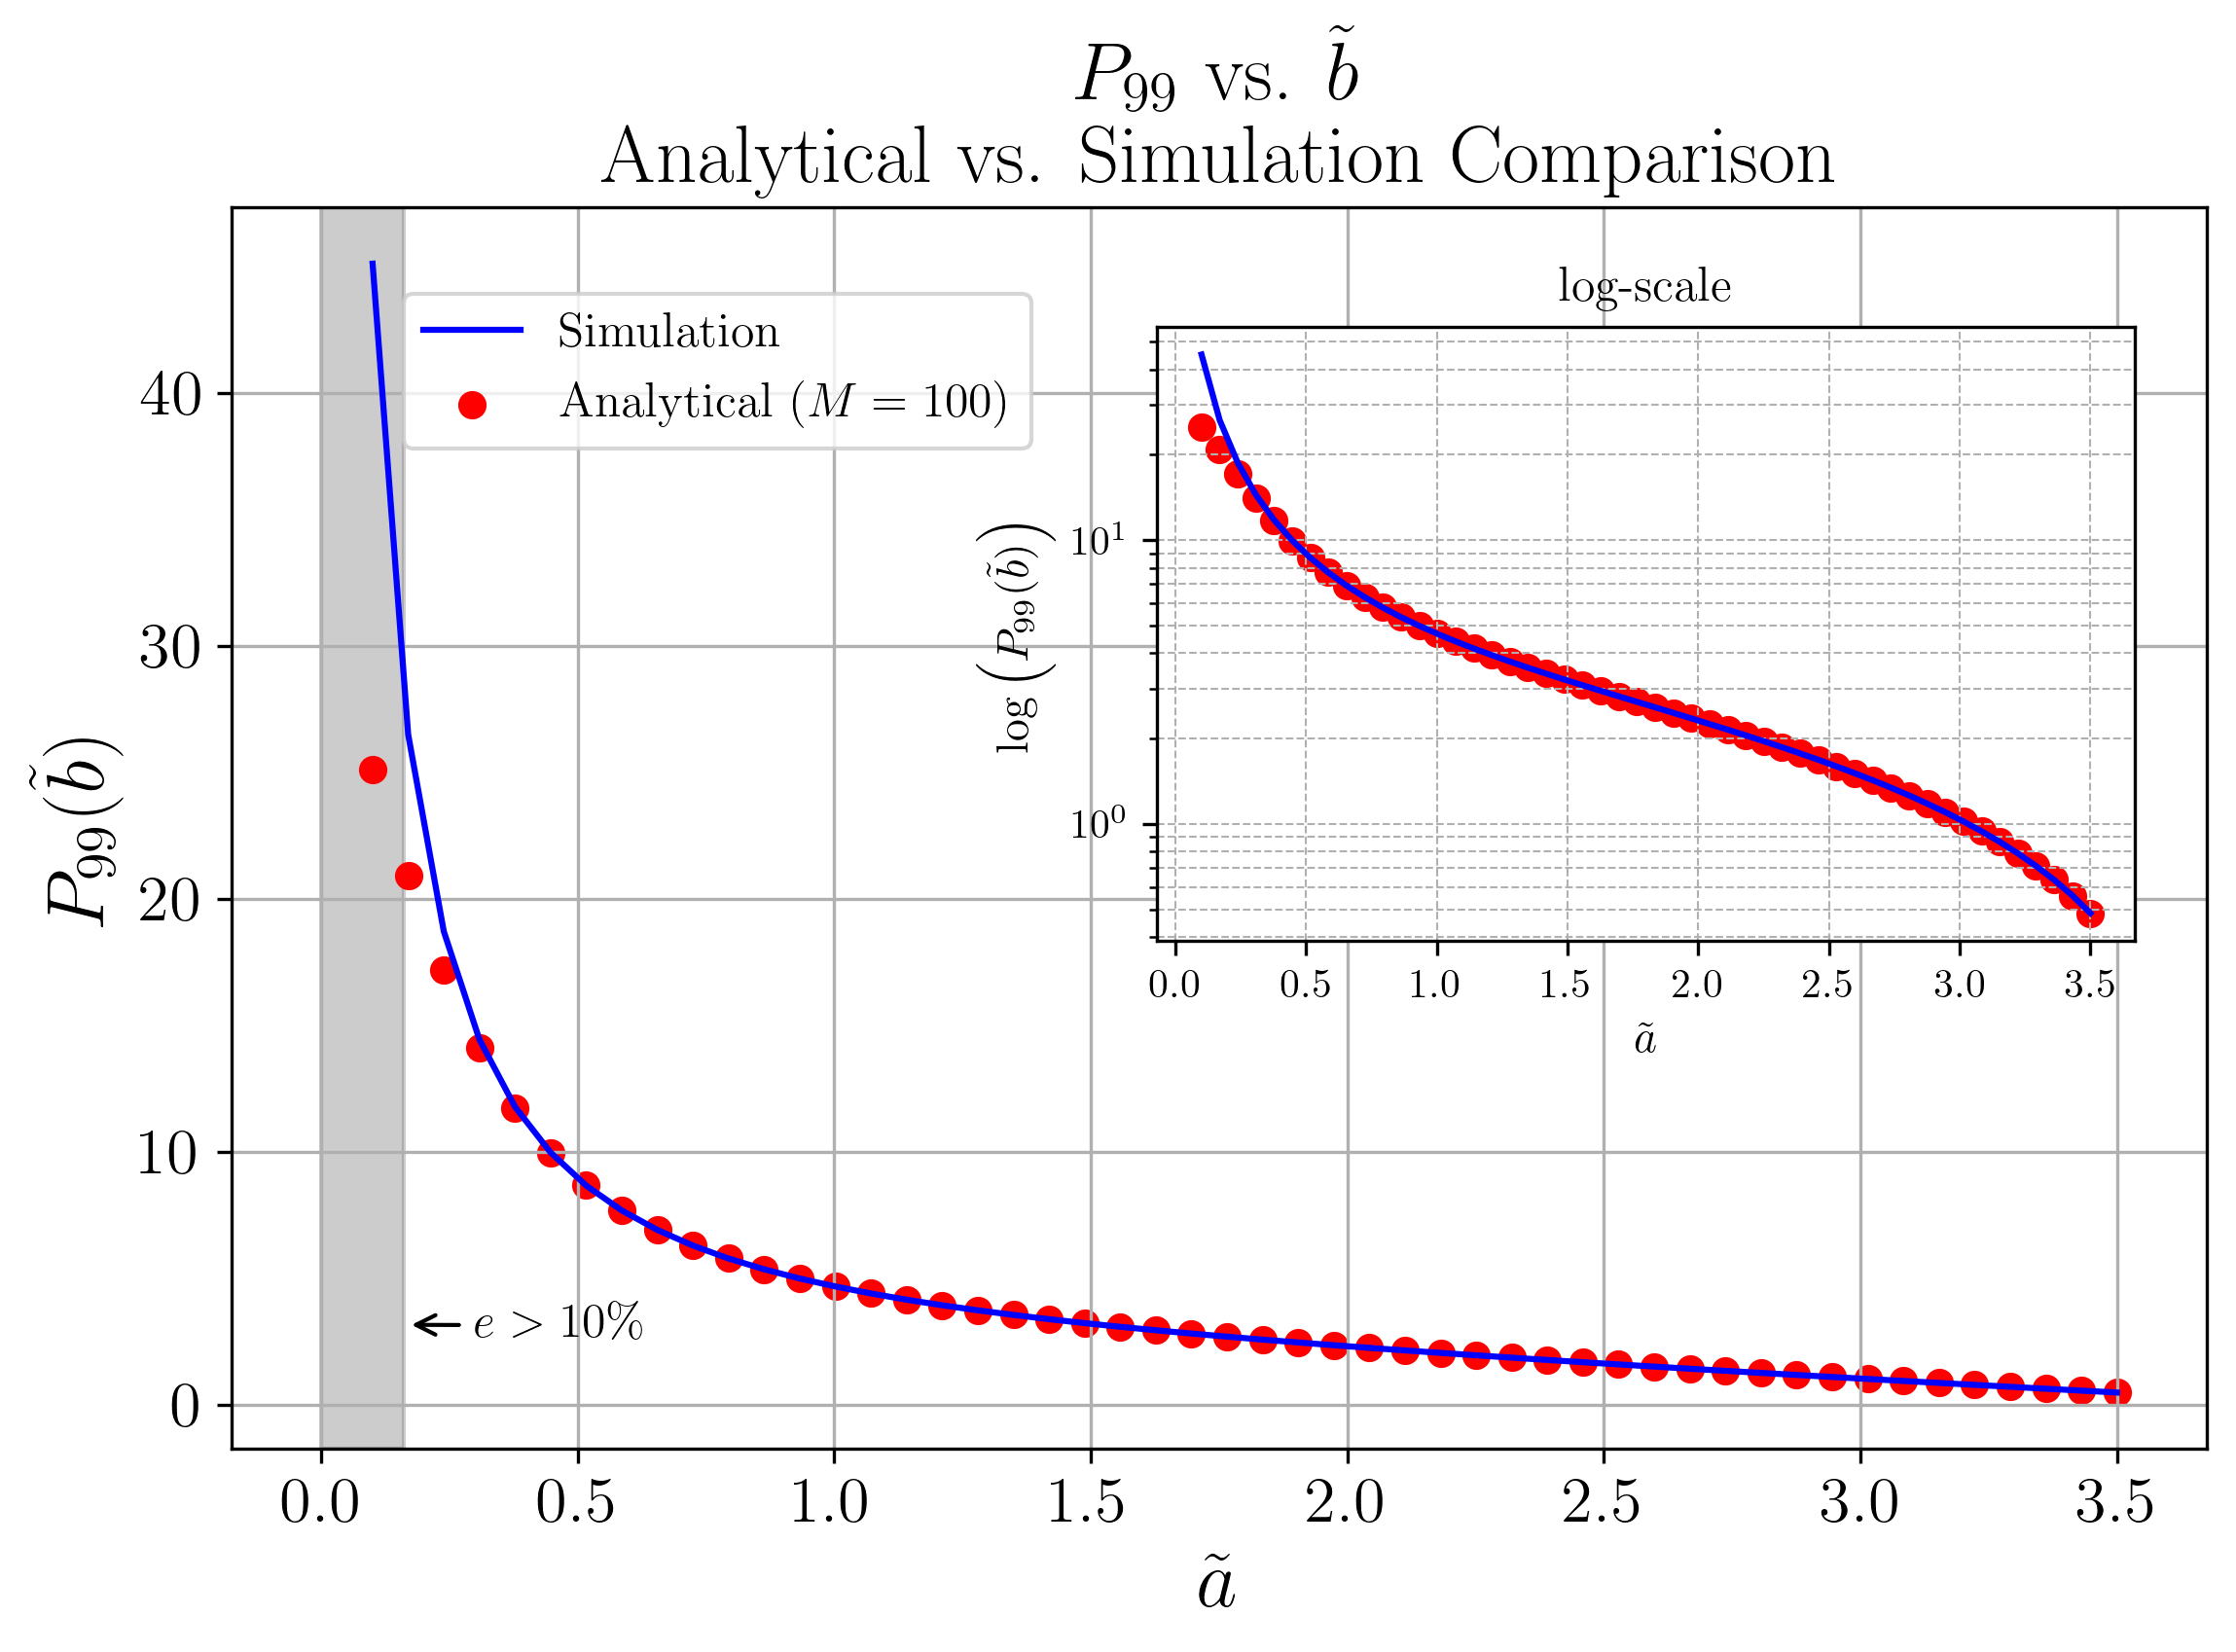

In [ ]:
M_val = 100
p99_vals = []
active_frac_vals = []
for i, a_tilde_val in enumerate(a_tilde_values):
    a_val = a_values[i]

    BESS, b_sim, g_sim, p0_sim, p99_sim = algorithmic_solution(a_tilde_val, beta, P_inf, dt, grid)

    b_ana, g_ana, p0_ana, p99_ana = analytical_solution(
            a_val, beta, M=M_val, b_max=40, n_grid=10001
        )
    
    p99_vals.append({"p99_sim": p99_sim, "p99_ana": p99_ana})

# --- FIGURE ---
RQ_12_FIGURE(a_tilde_values, p99_vals, M_val)

### RQ 1.3: Convergence analysis to 95% of similarity to the stationary state pdf vs M terms

In [10]:
# --- Parallelized loop ---
@njit
def M_for_convergence(a_val, P, dt, a_tilde_val, beta, grid, max_M, DM_tol):
    
    _, b_sim, g_sim, _, _ = algorithmic_solution(a_tilde_val, beta, P, dt, grid)
    b_max = np.max(b_sim)

    DM = 1.0
    M_val = 0

    while DM > DM_tol and M_val <= max_M:
        
        b_ana, g_ana, p0_ana, _ = analytical_solution(
            a_val, beta, M=M_val, b_max=b_max, n_grid=grid
        )
        g_ana = g_ana / (1.0 - p0_ana)

        delta_b = b_ana[1] - b_ana[0]
        g_diff = np.abs(g_sim - g_ana)

        DM = trapezoid_integral(g_diff, delta_b)

        M_val += 1

    return M_val, DM


@njit(parallel=True)
def M_vs_a(a_sim, P, dt, a_tilde_sim, beta, grid,
                      max_M, DM_tol):
    n = a_sim.size

    M_vals = np.empty(n, dtype=np.int64)
    DM_vals = np.empty(n, dtype=np.float64)

    for i in prange(n):
        a_val = a_sim[i]
        a_tilde_val = a_tilde_sim[i]

        M_val, DM = M_for_convergence(
            a_val, P, dt, a_tilde_val, beta, grid,
            max_M=max_M, DM_tol=DM_tol
        )

        M_vals[i] = M_val
        DM_vals[i] = DM
    return M_vals, DM_vals


# --- M convergence exploration --- 
tol = 0.05
M_vals, DM_vals = M_vs_a(
    a_values, P_inf, dt, a_tilde_values, beta, grid, max_M=500, DM_tol=tol
)

0.7244897959183673
1.6959183673469387


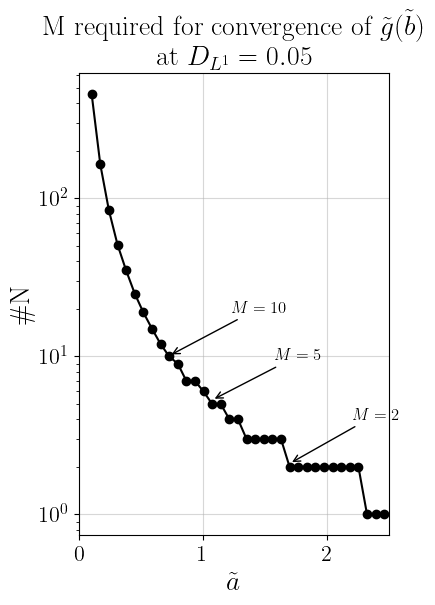

In [11]:
M_convergence = [{"a_tilde": a_tilde_values[i], "M": int(M_vals[i]), "DM": float(DM_vals[i])} for i in range(len(a_values))]

RQ_13_FIGURE(a_tilde_values, M_convergence)

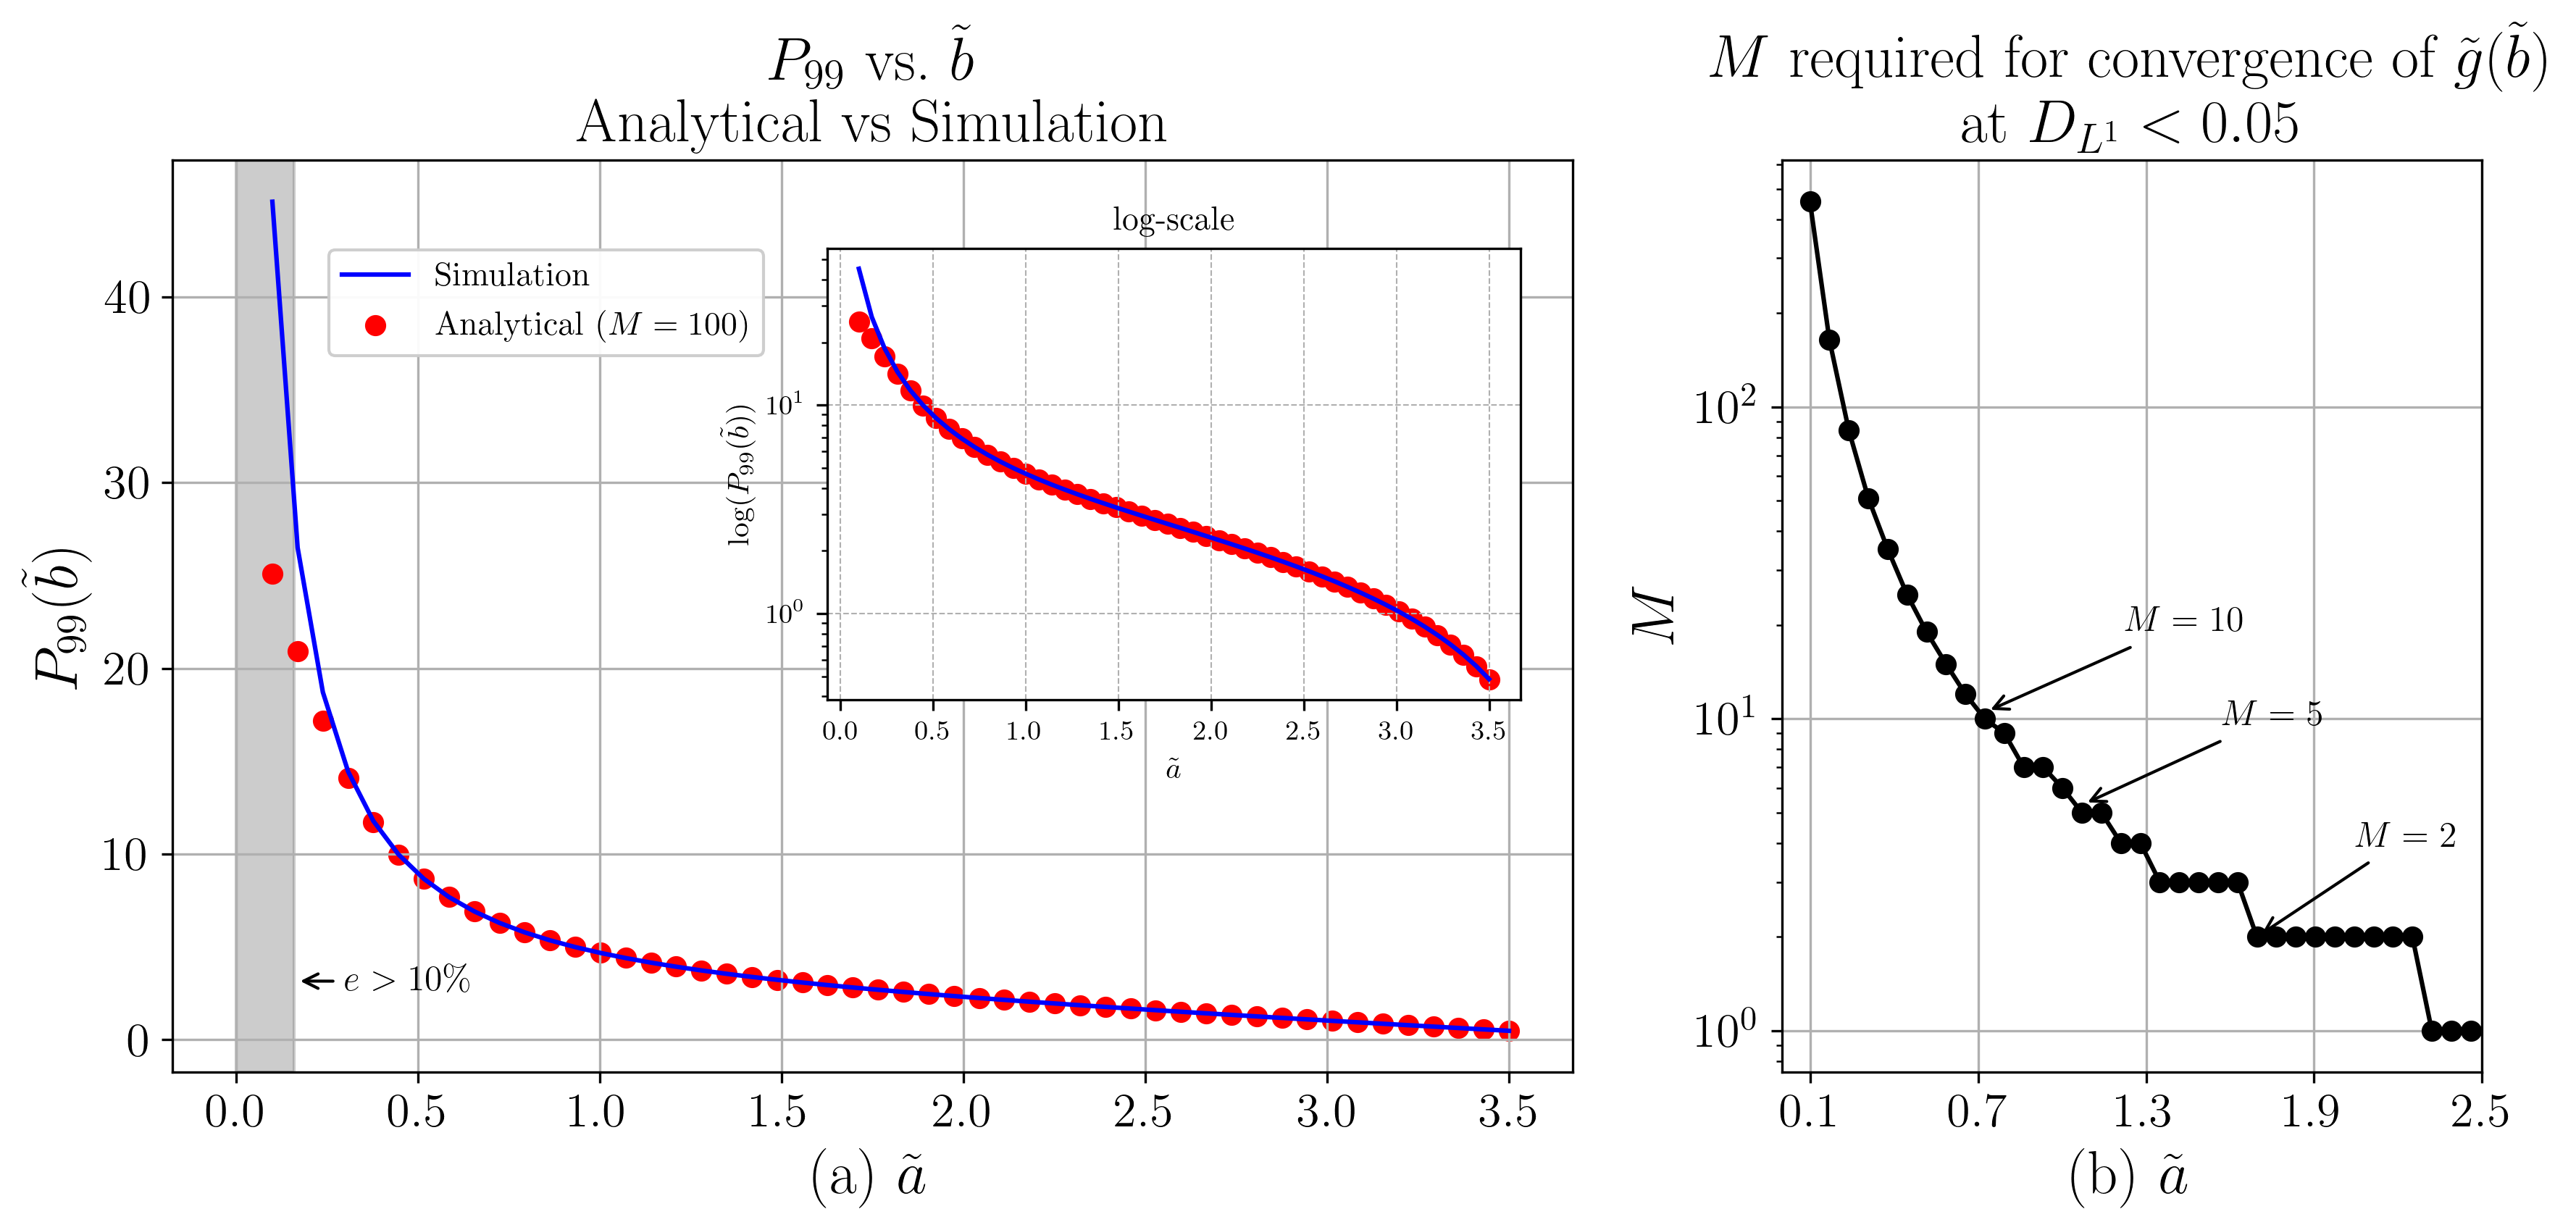

In [25]:
# --- COMBINED FIGURE FOR RQ 1.2 AND RQ 1.3 ---
RQ_12_13_FIGURE(a_tilde_values, p99_vals, M_convergence)

### RQ 1.4: Are results only dependent on $\tilde{a}$ or they depende on $a$ and $\beta$ independently?

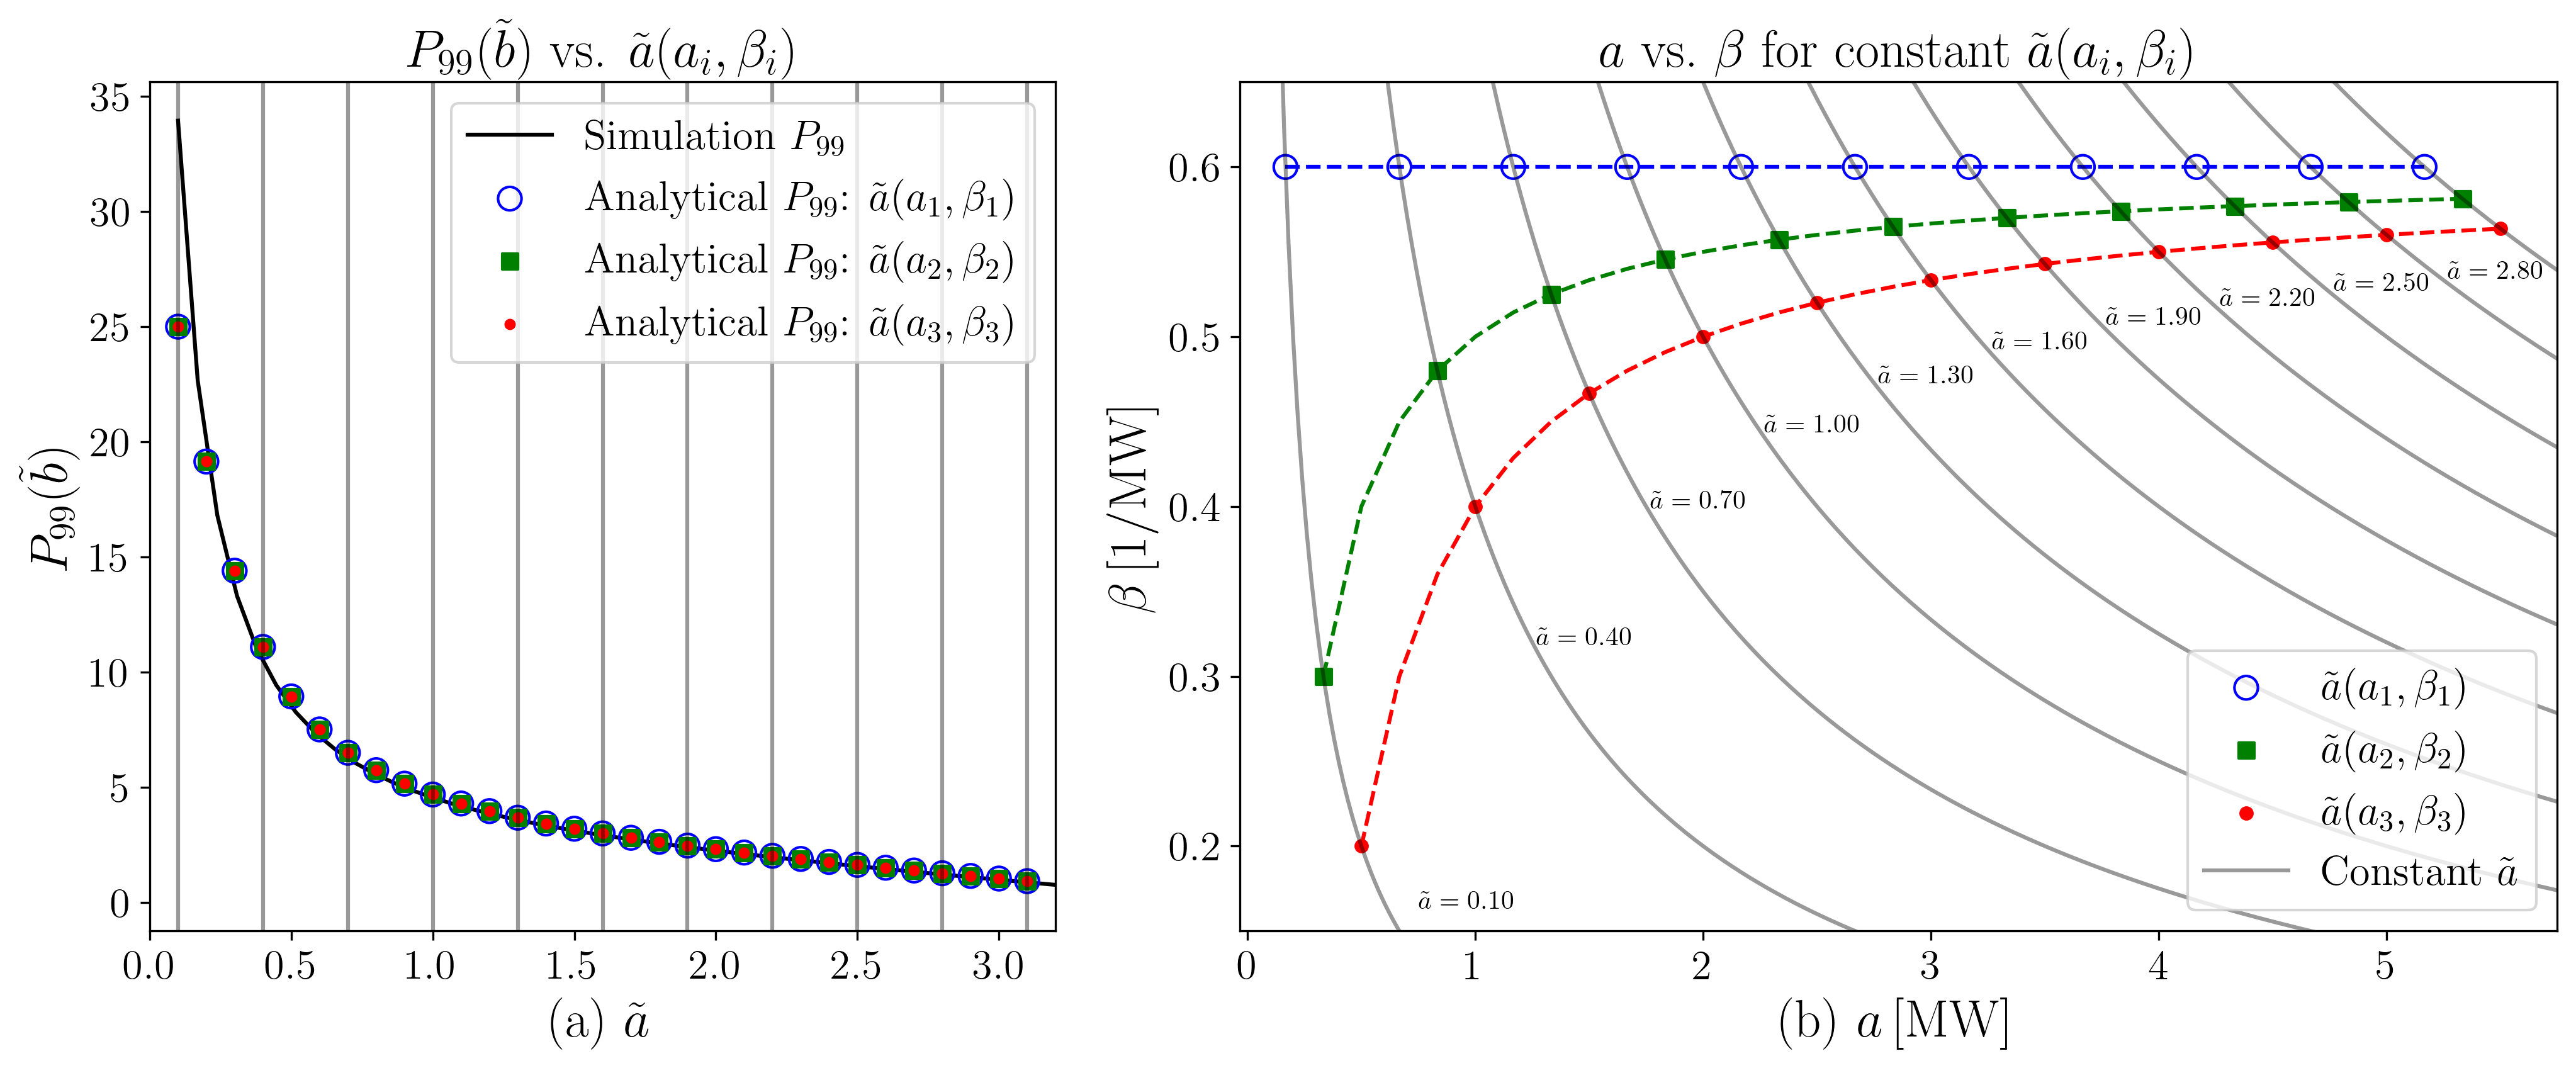

In [33]:
p99_simVals = []
for i, a_tilde_val in enumerate(a_tilde_values):
    #a_val = a_values[i]
    BESS, b_sim, g_sim, p0_sim, p99_sim = algorithmic_solution(a_tilde_val, beta, P, dt, grid)
    p99_simVals.append(p99_sim)

alpha_values_ana = np.linspace(min(alpha_values), max(alpha_values), 35)             # MW/MIN (ALPHA)
a_values_ana = alpha_values_ana * dt
a_tilde_values_ana = beta * a_values_ana

p99_aTilde_Vals = []
for i in range(len(a_values_ana)-4):
    a_val = np.asarray([float(a_values_ana[i]), float(a_values_ana[i+1]), float(a_values_ana[i+2]), float(a_values_ana[i+3])+0.1])
    beta_val = np.asarray(a_tilde_values_ana[i]) / a_val
    a_tilde_ana = beta_val * (a_val)

    p99_anaVals = np.zeros(4)
    for j in range(4):
        a_j = a_val[j]
        beta_j = beta_val[j]

        # --- Analytical Solver ---
        b_ana, g_ana, p0_ana, p99_ana = analytical_solution(
                a_j, beta_j, M=100, b_max=50, n_grid=grid
        )
        p99_anaVals[j] = p99_ana
        
    p99_aTilde_Vals.append({"a": a_val, "beta": beta_val, "A_tilde": a_tilde_ana, "p99": p99_anaVals})

RQ_141_142_FIGURE(a_tilde_values, p99_simVals, p99_aTilde_Vals)

### RQ 2.1: Consistency between analytical and numerical solutions

In [11]:
def simulation_and_solvers(a, beta, dt, P, grid, M):
    # MAKE THEM TILDE AND GENERATE THE CONTROL BATTERY "B"
    a_tilde = beta * a          # ã = β a

    # --- Simulation of b_tilde ---
    t0_sim = time.perf_counter()
    _, b_sim, g_sim, p0_sim, p99_sim = algorithmic_solution(a_tilde, beta, P, dt, grid)
    t1_sim = time.perf_counter()

    b_max = np.max(b_sim)

    # --- Nystrom solver ---
    t0_nys = time.perf_counter()
    b_nys, g_nys, p0_nys, p99_nys = numerical_solution(
        a=a, beta=beta, b_max=b_max, n_grid=grid-1
    )
    t1_nys = time.perf_counter()

    # --- Analytical solver ---
    t0_ana = time.perf_counter()
    b_ana, g_ana, p0_ana, p99_ana = analytical_solution(
        a, beta, M=M, b_max=b_max, n_grid=grid
    )
    t1_ana = time.perf_counter()

    sim_time = t1_sim - t0_sim
    nys_time = t1_nys - t0_nys
    ana_time = t1_ana - t0_ana

    sim_results = (b_sim, g_sim, p0_sim, p99_sim, sim_time)
    nys_results = (b_nys, g_nys, p0_nys, p99_nys, nys_time)
    ana_results = (b_ana, g_ana, p0_ana, p99_ana, ana_time)

    return sim_results, nys_results, ana_results


# --- Evaluating smaller M value for D_L^1 = 0.01 with a = 0.9 ---
M_value, DM_value = M_for_convergence(a, P_inf, dt, a_tilde, beta, grid, 200, 0.01);print(f"M_value: {M_value}")

res_sim, res_nys, res_ana = simulation_and_solvers(a, beta, dt, P_inf, grid, M_value)

b_sim, g_sim, p0_sim, p99_sim, sim_time = res_sim
b_ana, g_ana, p0_ana, p99_ana, ana_time = res_ana
b_nys, g_nys, p0_nys, p99_nys, nys_time = res_nys

delta_b    = b_ana[1] - b_ana[0]
g_diff_ana = np.abs(g_sim - g_ana / (1 - p0_ana))
DM_ana     = np.trapezoid(g_diff_ana, dx=delta_b); print(f"DM_ana = {DM_ana}"); print(f"ana_time: {ana_time}")

g_diff_nys = np.abs(g_sim - g_nys / (1 - p0_nys))
DM_nys     = np.trapezoid(g_diff_nys, dx=delta_b); print(f"DM_nys = {DM_nys}"); print(f"nys_time: {nys_time}")

# --- RQ 2.1 FIGURE ---
#RQ_21_FIGURE(res_sim, res_nys, res_ana)

M_value: 17
DM_ana = 0.00941985851260248
ana_time: 0.004163799996604212
DM_nys = 0.008437521280638882
nys_time: 0.04418969999824185


### RQ 2.2 Computing time of analytical solution against M terms

In [7]:
# ------------------------------------------------------------------------
# Computing time for analytical solution in function of M 
# ------------------------------------------------------------------------

# --- Analytical time complexity vector ---
M_values = np.linspace(1, 200, 60).astype(int)
grid = 1001

# --- Simulation of b_tilde ---
BESS, b_sim, g_sim, p0_sim, p99_sim = algorithmic_solution(a_tilde, beta, P_inf, dt, grid)
b_max       = np.max(b_sim) 

# Warm up JIT
_ = analytical_solution(a, beta, M=M_values[0], b_max=b_max, n_grid=grid)
time_vs_M = []
for M in M_values:
    t0 = time.perf_counter()
    _  = analytical_solution(a, beta, M=M, b_max=b_max, n_grid=grid)
    t1 = time.perf_counter()
    time_vs_M.append({"M": M, "time": float(t1 - t0)})  

# --- RQ 2.2 FIGURE ---
#RQ_22_FIGURE(M_values, time_vs_M)

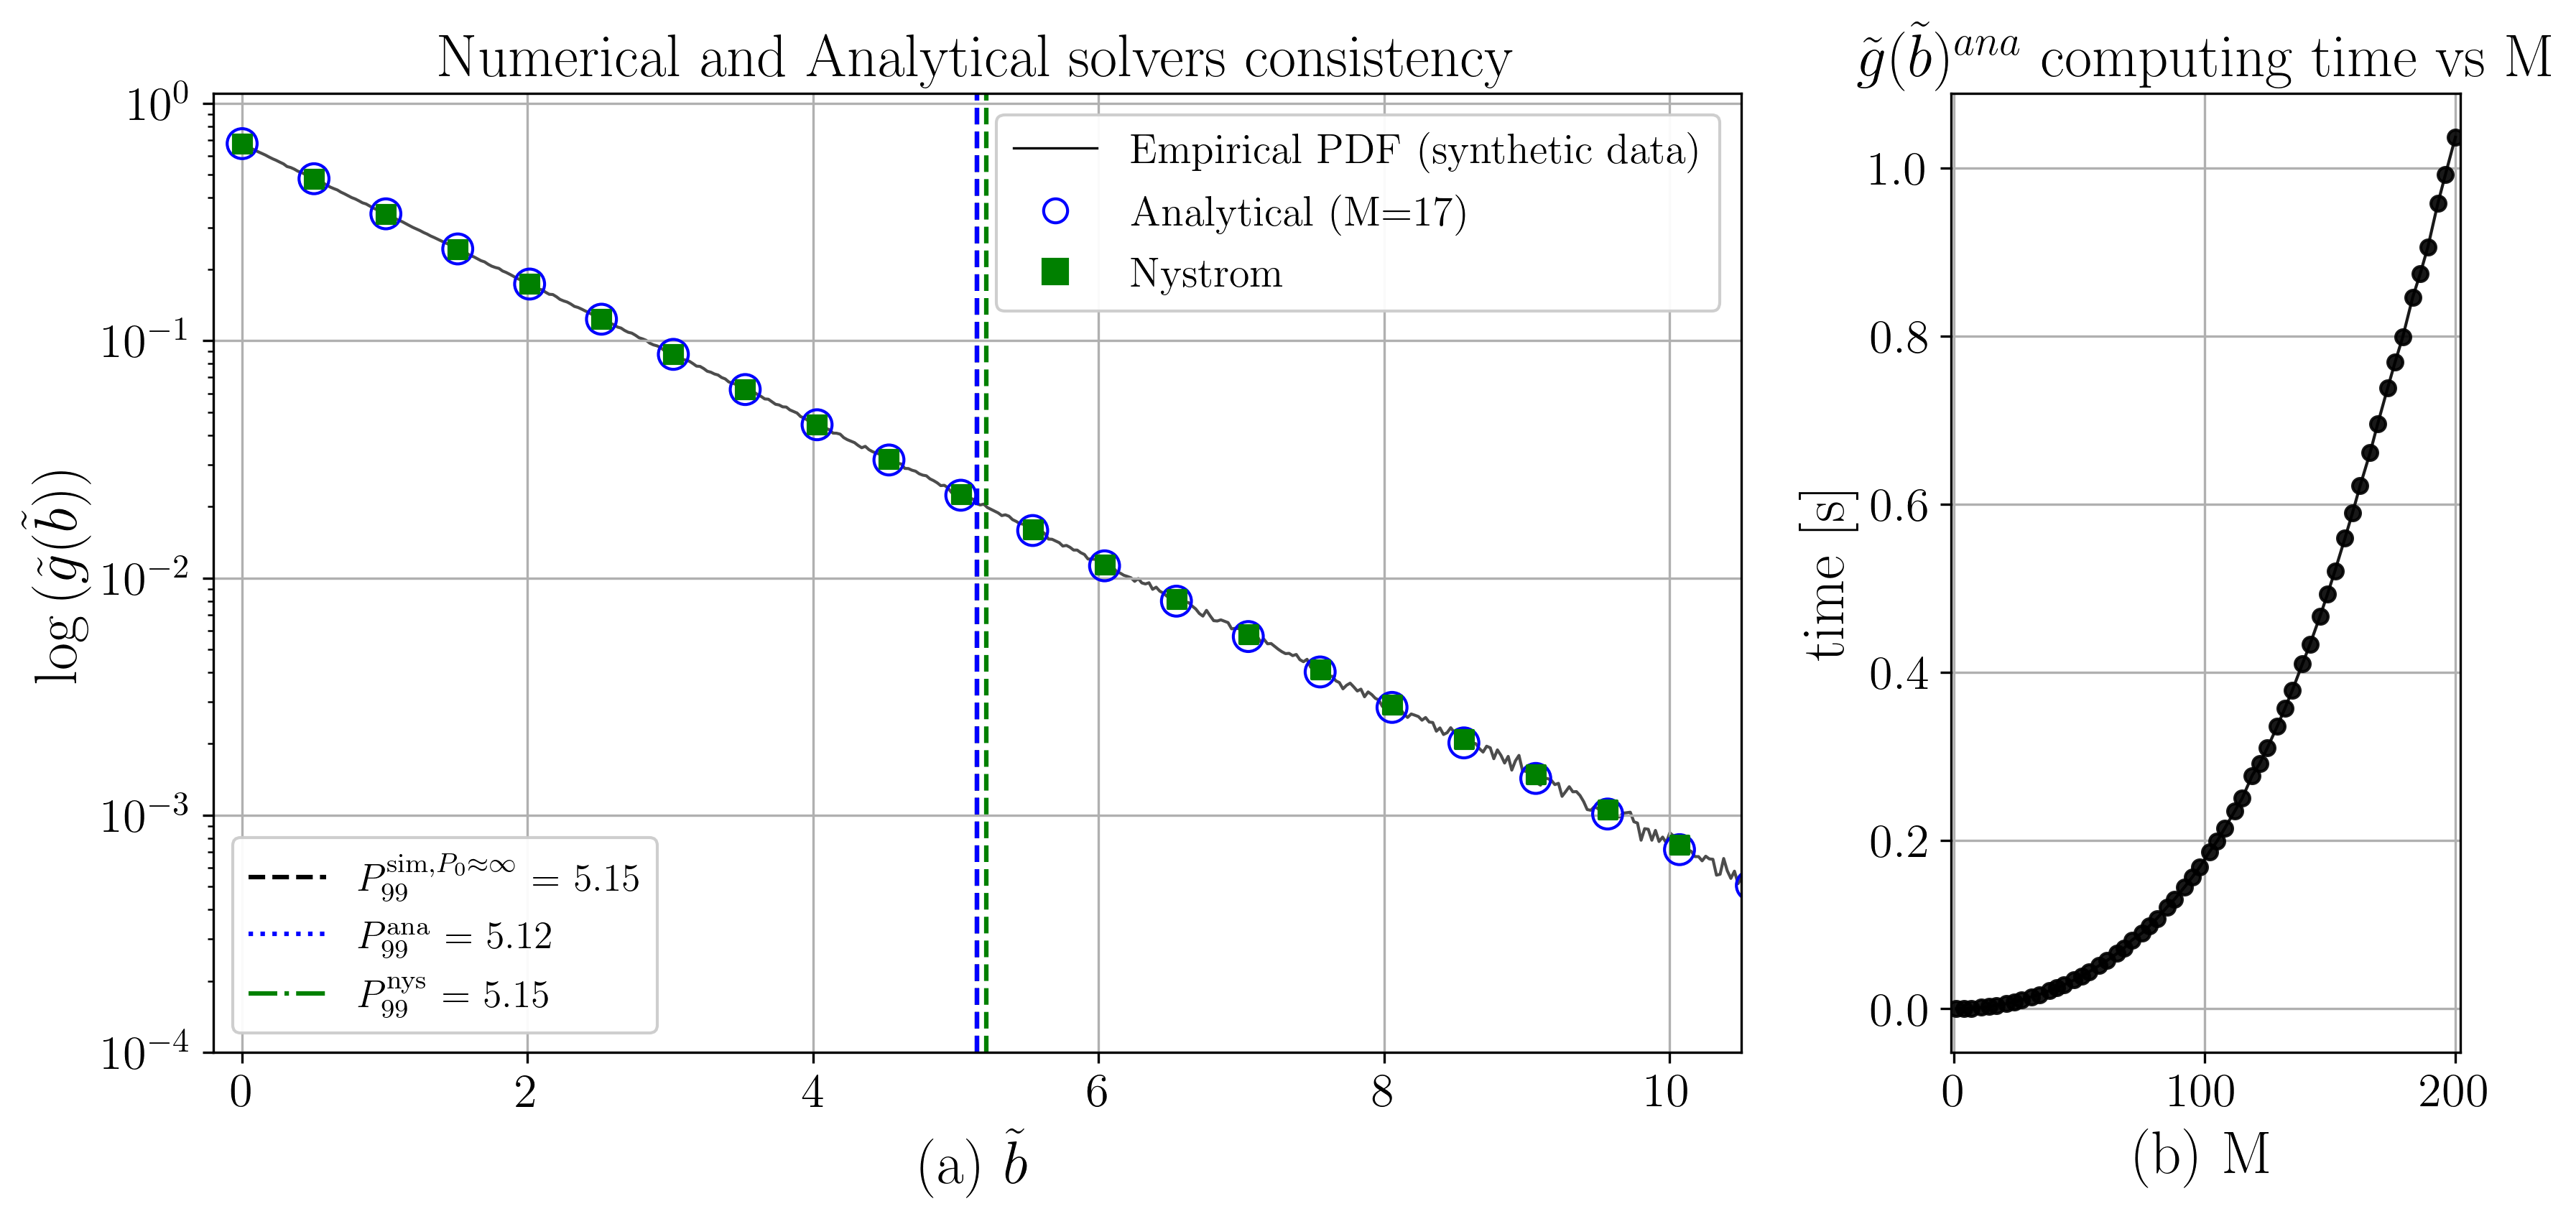

In [10]:
# --- COMBINED RQ 2.1 AND 2.2 FIGURE ---
RQ_21_22_FIGURE(res_sim, res_nys, res_ana, M_values, M_value, time_vs_M)

### RQ 3.1: Impact of GL distribution for different $\tilde{a}$ values

c:\Users\Diego\Documents\UNI\6 SEM\BESS Sizing\BESS_Sizing_Simulator\src\core_Figures.py:1086: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


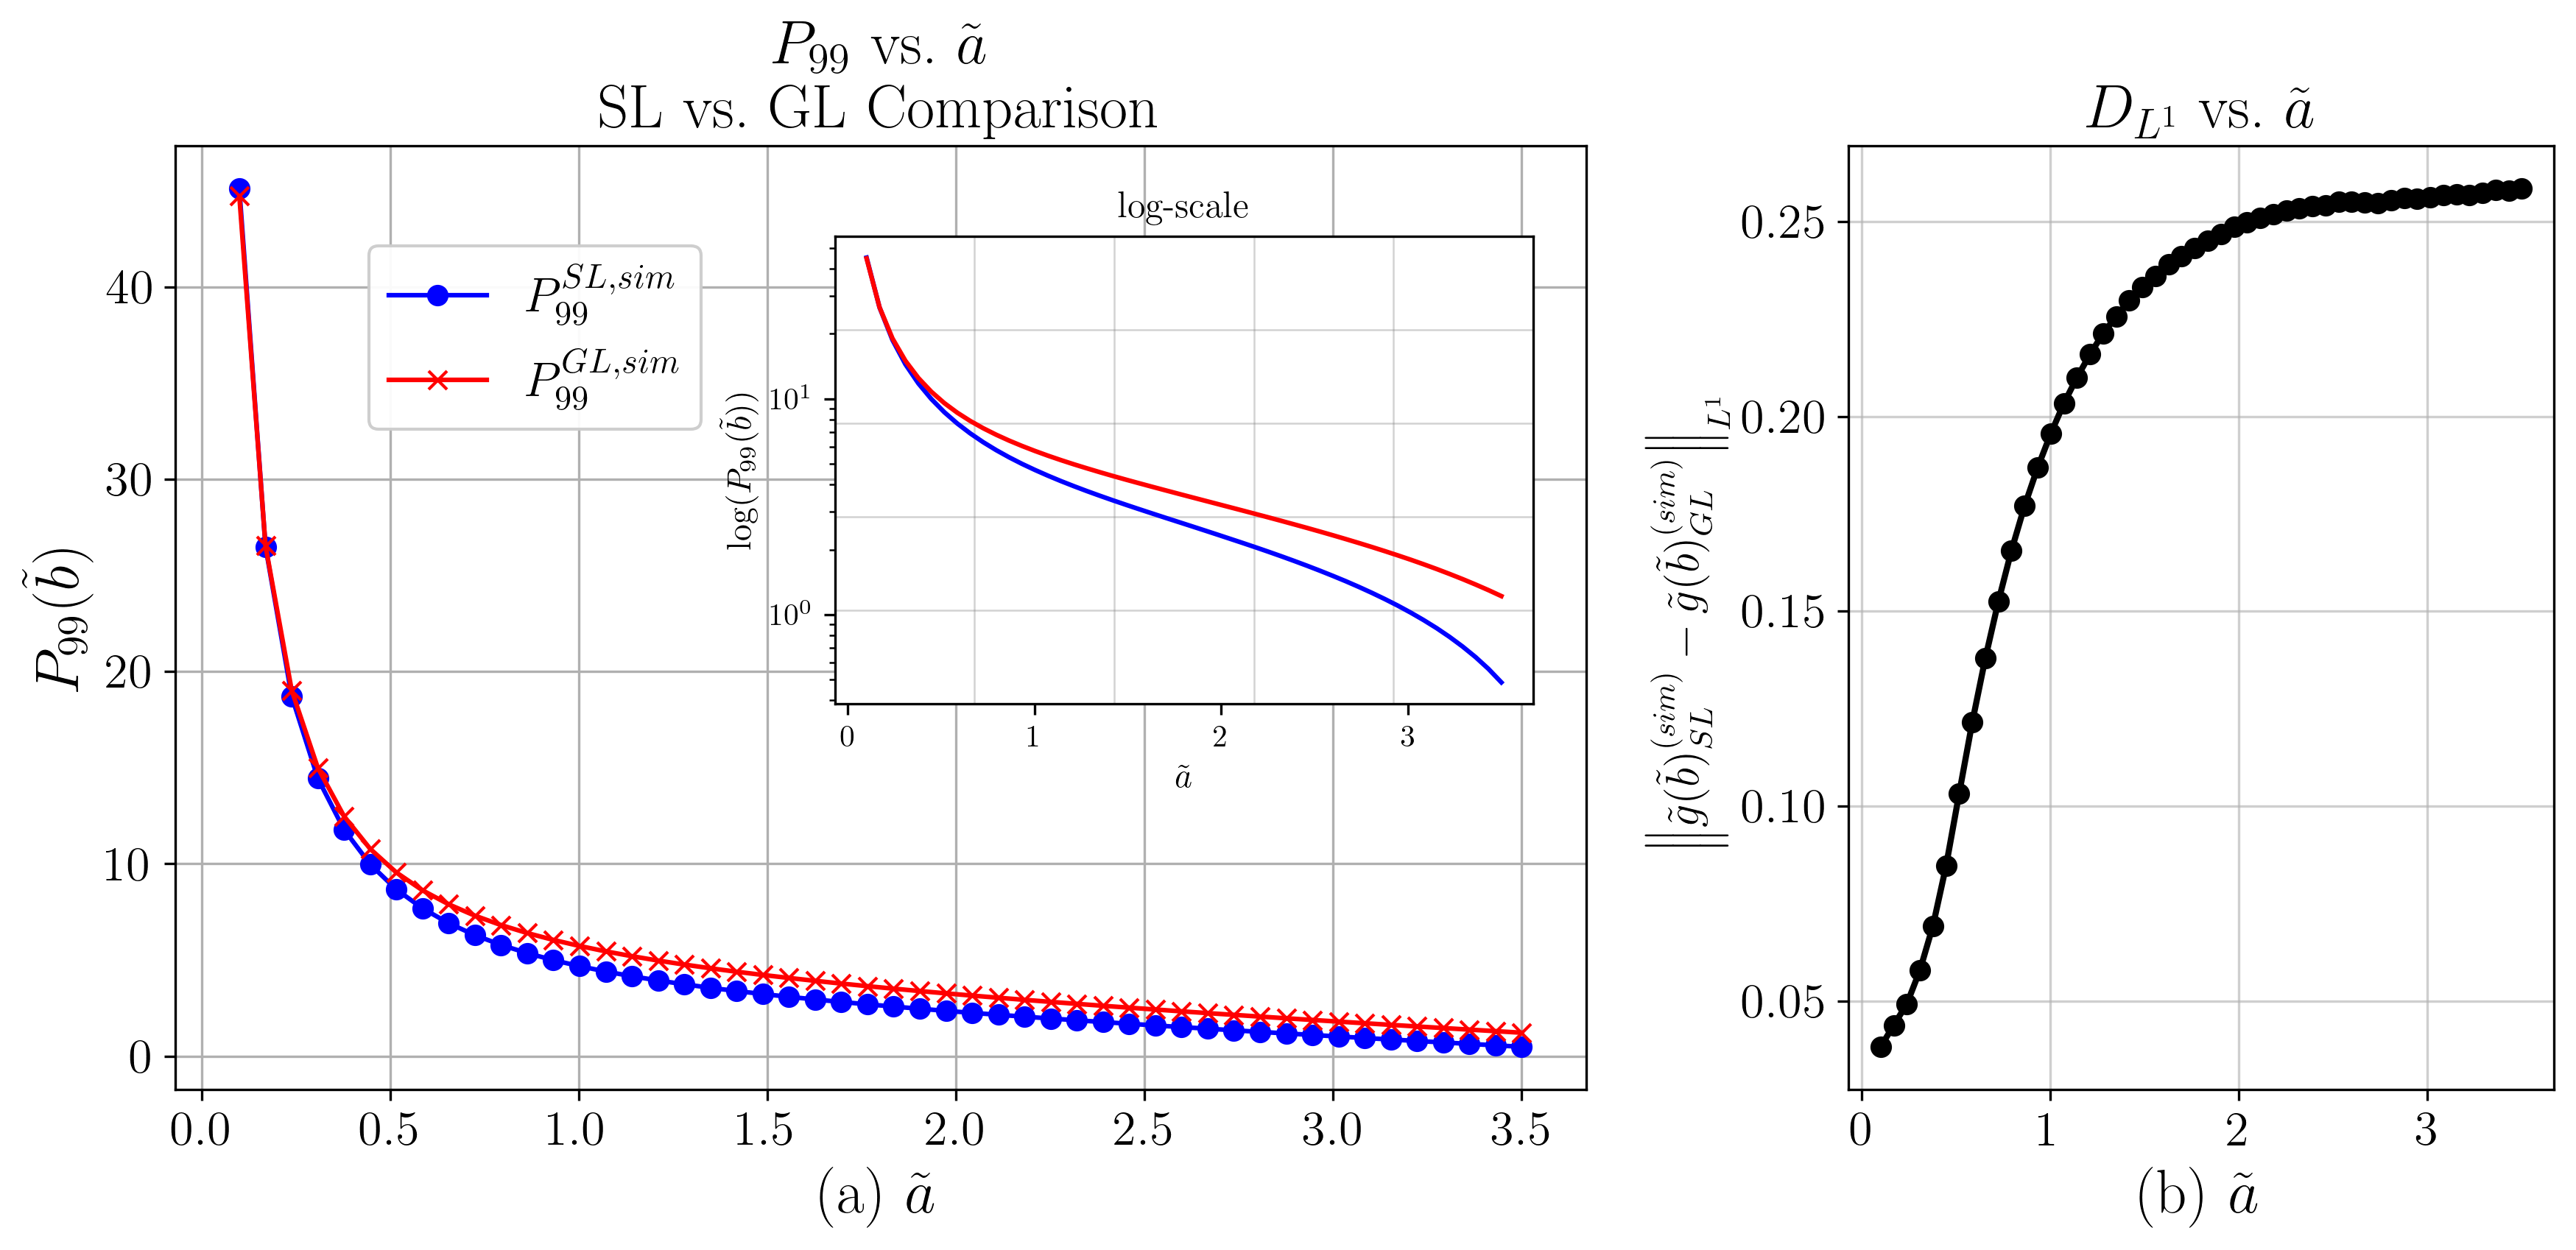

In [18]:
def GL_vs_SL(a_val, P_SL, P_GL, beta):
    grid = 10000  # número de puntos tanto para hist como para y_grid

    # ---------- Simple Laplace ----------
    a_tilde = beta * a_val       # ã = β a
    BESS_SL, b_sim, _, _, _ = algorithmic_solution(a_tilde, beta, P_SL, dt, grid)
    BESS_SL_mask = (BESS_SL > 1e-4)

    # ---------- Generalized Laplace ----------
    BESS_GL, b_sim, _, _, _ = algorithmic_solution(a_tilde, beta, P_GL, dt, grid)
    BESS_GL_mask  = (BESS_GL > 1e-4)

    # ---------- Grid común para ambos histogramas ----------
    b_all = np.concatenate([BESS_SL[BESS_SL_mask], BESS_GL[BESS_GL_mask]])
    bmin  = np.min(b_all)
    bmax  = np.max(b_all)

    # Bordes de bins comunes
    bin_edges = np.linspace(bmin, bmax, grid + 1)
    # Centros de bin comunes
    b_sim = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Histogramas en el MISMO grid
    g_sim_SL, _ = np.histogram(BESS_SL[BESS_SL_mask], bins=bin_edges, density=True)
    g_sim_GL, _ = np.histogram(BESS_GL[BESS_GL_mask], bins=bin_edges, density=True)

    simulations = {
        # uso el mismo b_sim para ambos (grid común)
        "SL": (BESS_SL, b_sim, g_sim_SL),
        "GL": (BESS_GL, b_sim, g_sim_GL),
    }

    return simulations



p99_SL_vec        = np.zeros(len(a_values))
p99_GL_vec        = np.zeros(len(a_values))
q_SL_for_a_values = np.zeros(len(a_values))
q_GL_for_a_values = np.zeros(len(a_values))
L1_norm           = np.zeros(len(a_values))
for i, a_val in enumerate(a_values):
    simulations = GL_vs_SL(a_val, P_inf, P_GL, beta)
    b_SL, b_sim_SL, g_sim_SL = simulations["SL"]
    b_GL, b_sim_GL, g_sim_GL = simulations["GL"]

    # --- Probability mass comparison ---
    delta_b = b_sim_SL[1] - b_sim_SL[0]
    g_diff = np.abs(g_sim_SL - g_sim_GL)
    L1 = np.trapezoid(g_diff, dx=delta_b )

    # --- BESS P99 value for GL and SL
    p99_SL = np.quantile(b_SL, 0.99)
    p99_GL = np.quantile(b_GL, 0.99)

    # --- Associated quantile of a_tilde in fY for SL and GL ---
    q_SL_for_a = np.mean(Y <= a_val)
    q_GL_for_a = np.mean(Y_GL <= a_val)

    p99_SL_vec[i]  = p99_SL
    p99_GL_vec[i]  = p99_GL
    L1_norm[i]     = L1
    q_SL_for_a_values[i] = q_SL_for_a
    q_GL_for_a_values[i] = q_GL_for_a

# --- RQ 3.1 and 3.2 figures ---
#RQ_31_FIGURE(a_tilde_values, p99_SL_vec, p99_GL_vec)
#RQ_32_FIGURE(a_tilde_values, L1_norm)
RQ_31_32_FIGURE(a_tilde_values, p99_SL_vec, p99_GL_vec, L1_norm)

### RQ 3.3 Influence of c and on the GL BESS distribution

c:\Users\Diego\Documents\UNI\6 SEM\BESS Sizing\BESS_Sizing_Simulator\src\core_Figures.py:1153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


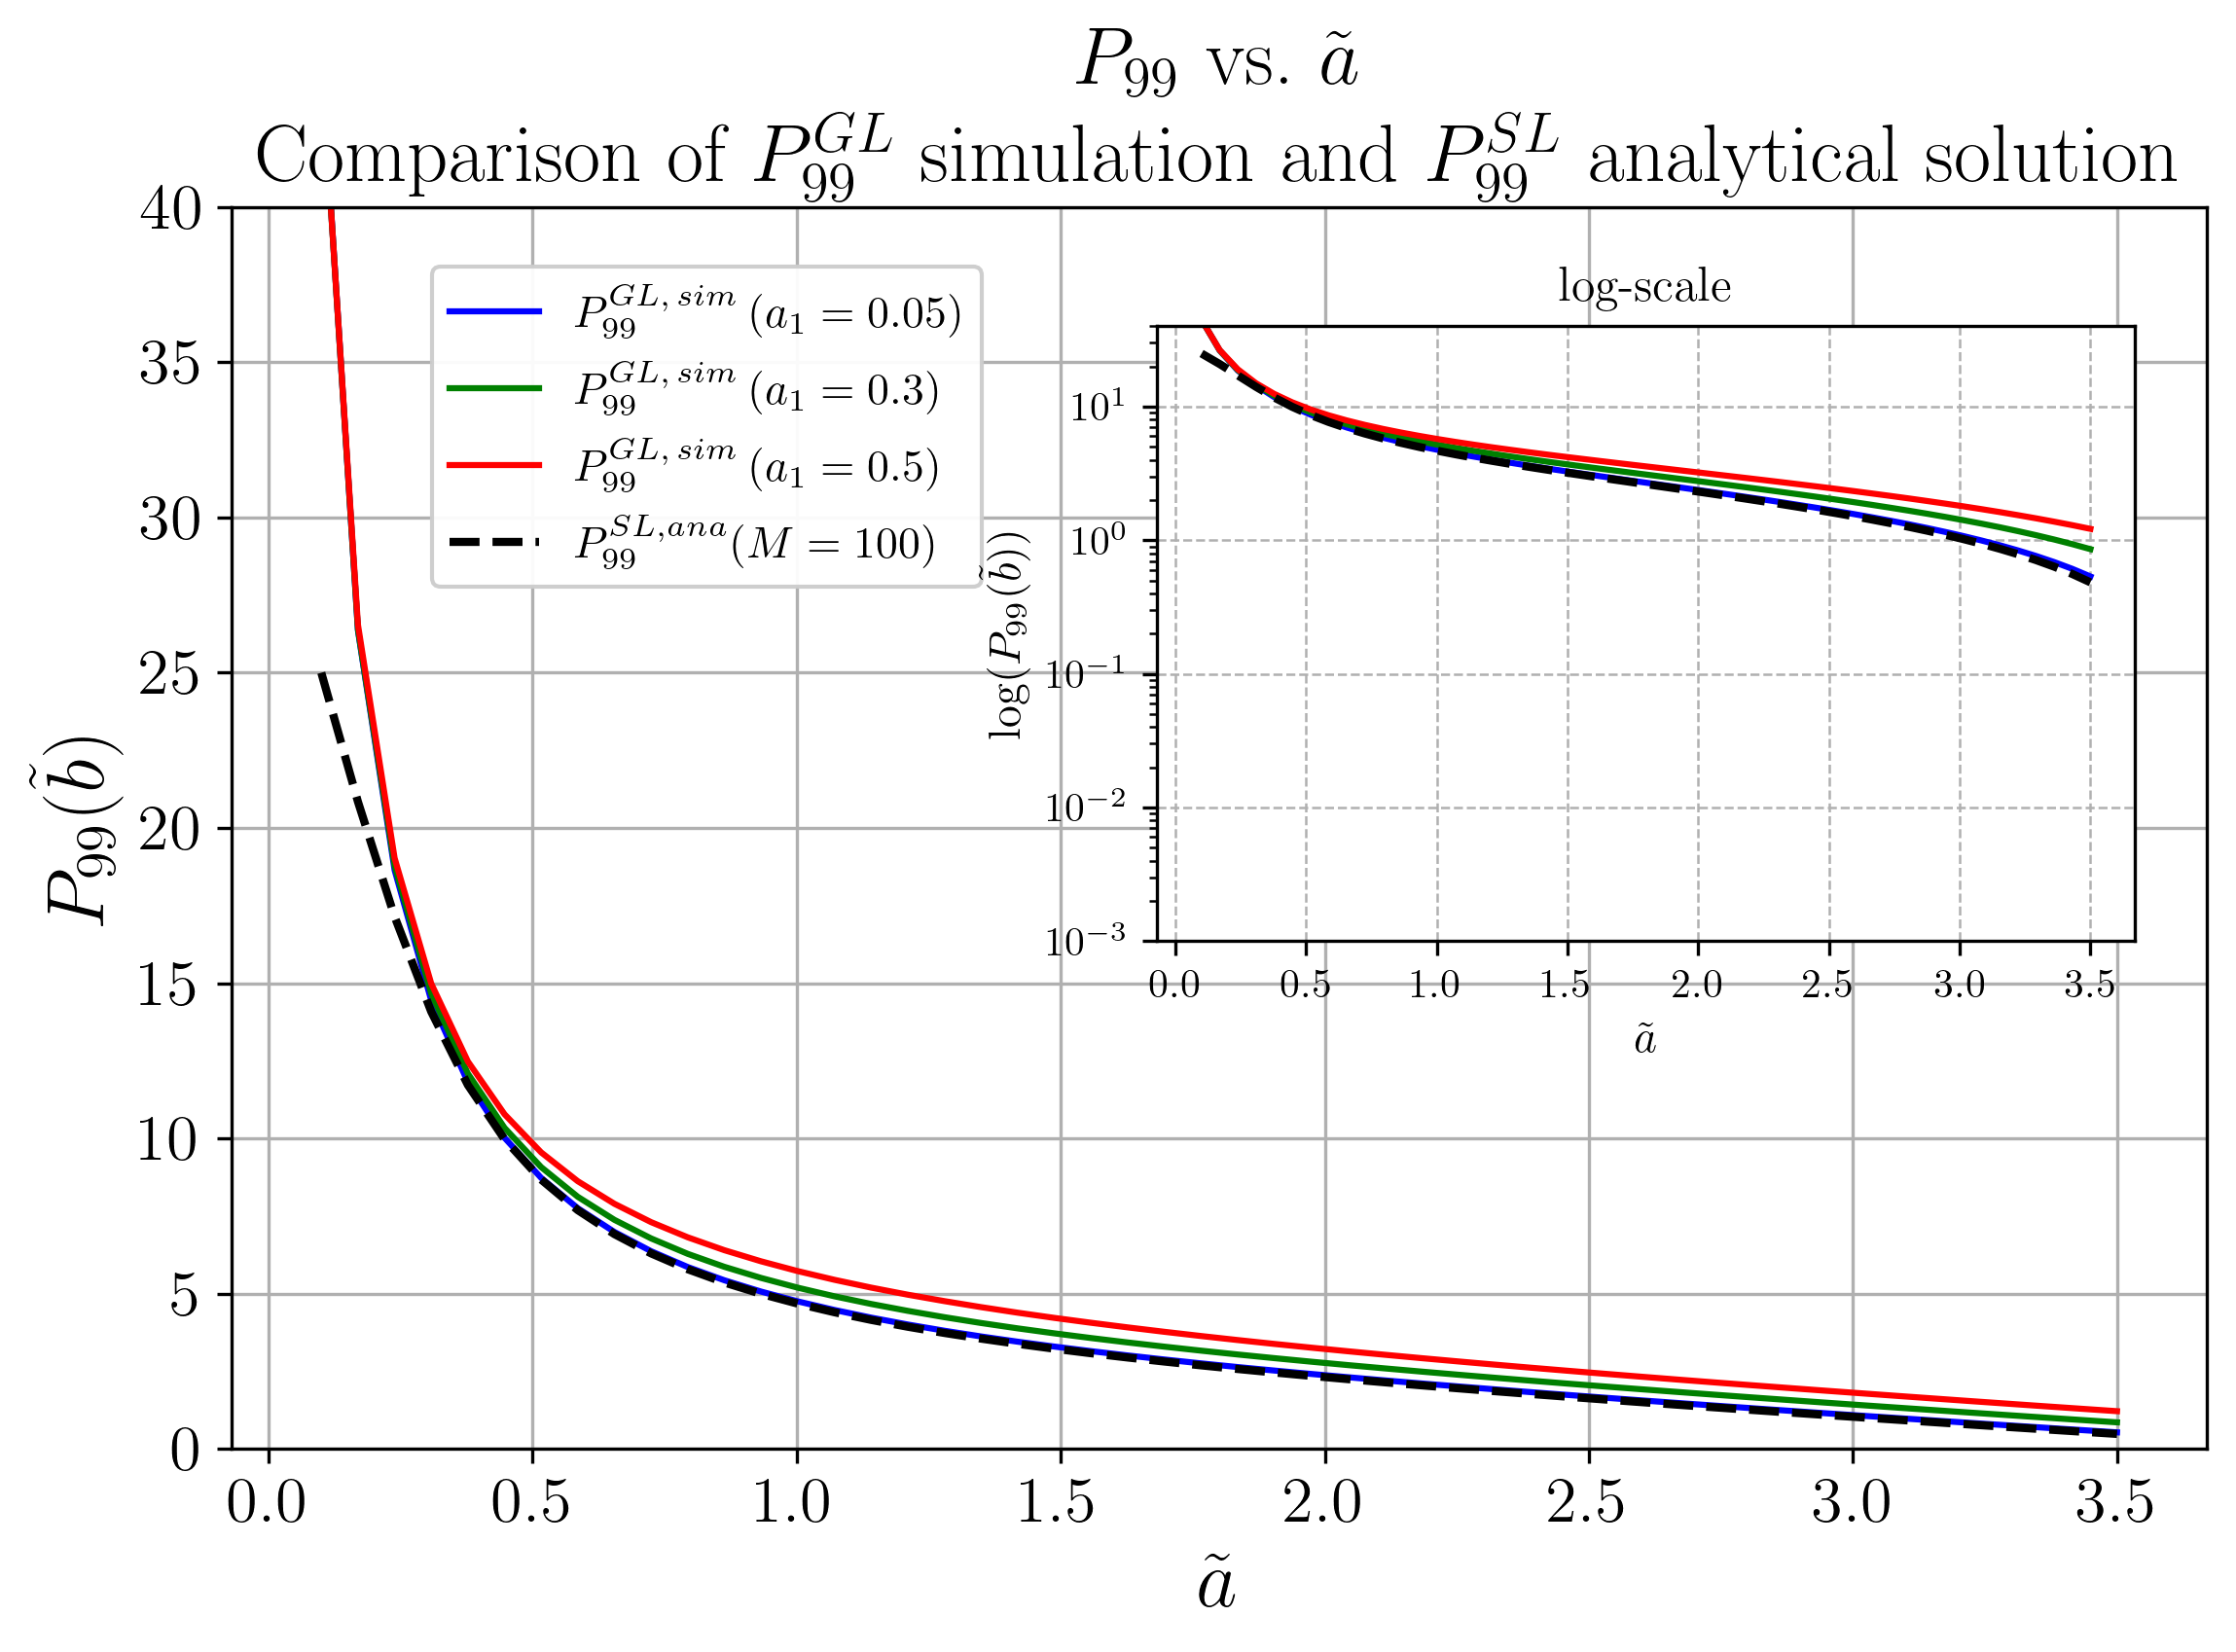

In [14]:
@njit(parallel=True)
def p99_curve_vs_c(a_values, beta, N, grid, dt, Pmax_inf, bernoulli_exp, seeds):
    c_values = np.asarray([0.05, 0.3, 0.5])
    #  --- GL simulation ---
    p99_GL_c_vs_a  = np.zeros((len(c_values), len(a_values)))
    L1_norm_c_vs_a = np.zeros((len(c_values), len(a_values)))

    for i, c in enumerate(c_values):
        # --- Generalized Laplace  ----
        c2      = 1.0 - c
        zeta    = 10
        beta_gl = beta * np.sqrt(c/(zeta**2) + c2)
        b = zeta * beta_gl

        _, P_GL = simulate_Y_P_GL(
            N, Pmax_inf, 77, c, c2, b, beta_gl, bernoulli_exp, seeds
            )

        p99_GL_vec     = np.zeros(len(a_values))
        L1_norm        = np.zeros(len(a_values))
        p99_ana_values = np.zeros(len(a_values))

        for j in prange(len(a_values)):
            a = a_values[j]
            a_tilde = a * beta
            # Smoothing once per c
            BESS_GL, _, g_sim_GL, _, p99_GL = algorithmic_solution(a_tilde, beta, P_GL, dt, grid)
            BESS_GL_mask = (BESS_GL > 1e-4)
            bmax = np.max(BESS_GL[BESS_GL_mask])

            # --- Neumann solver on analytical grid ---
            b_ana, g_ana, _, p99_ana = analytical_solution(
                a, beta, M=100, b_max=bmax, n_grid=grid
            )

            delta_b = np.abs(b_ana[1] - b_ana[0])
            g_diff = np.abs(g_sim_GL - g_ana)
            L1 = trapezoid(g_diff, dx=delta_b)

            p99_GL_vec[j]     = p99_GL
            L1_norm[j]        = L1
            p99_ana_values[j] = p99_ana

        p99_GL_c_vs_a[i, :]  = p99_GL_vec
        L1_norm_c_vs_a[i, :] = L1_norm

    return p99_GL_c_vs_a, L1_norm_c_vs_a, p99_ana_values, c_values

r_values = np.linspace(0.1, 3.5, 50) / (beta * Pmax)    # [1/MIN]
alpha_values = r_values*60*Pmax                       # [MW/HR] (ALPHA)
a_values = alpha_values * dt                          # [MW/MIN]
a_tilde_values = a_values * beta
p99_GL_c_vs_a, L1_norm_c_vs_a, p99_ana_values, c_values = p99_curve_vs_c(a_values, beta, N, grid, 
                                                                         dt, Pmax_inf, bernoulli_exp, seeds)

# --- RQ 3.3 FIGURE ---
RQ_33_FIGURE(a_tilde_values, p99_GL_c_vs_a, p99_ana_values, c_values)